# setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install sentence_transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_trans

In [3]:
# import

import random
import math
import numpy as np
import logging
from datetime import datetime
import pandas as pd
import os
import csv
from typing import List, Union
from tqdm.autonotebook import trange

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util, SentencesDataset
from sentence_transformers.evaluation import SentenceEvaluator, TripletEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

<ipython-input-3-e96b76b519c6>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# dataset

In [4]:
# wa3i 프로젝트 데이터
wa3i_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_wai.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
wa3i_data = wa3i_data.dropna(how='any')
wa3i_data

,sentence1,sentence2,gold_label
0,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자가 먹을 것이 없어 죽게되고 분해자도 소비자가 다 죽어 소비자...,entailment
1,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 생태계에 없으면 소비자와 분해자가 먹을것을 못먹는다.못먹는 소비자와 분해자...,entailment
2,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 있지 않으면 생산자를 먹는 동물도 그 동물을 먹는 동물도 굶게 되어 생태계...,entailment
3,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자는 소비자와 분해자들에게 영양을 제공한다. 만약 생산자가 없다면 소비자는 영양...,entailment
4,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다,entailment
...,...,...,...
8721,부력에 의해 배를 띄울 수 있다.,물이 힘이있어서,contradiction
8722,부력에 의해 배를 띄울 수 있다.,파도를 이용하여 뜨게 하는것 같다,contradiction
8723,부력에 의해 배를 띄울 수 있다.,물체를 띄우는 힘인 부력을 활용한 것이다.,entailment
8724,부력에 의해 배를 띄울 수 있다.,배는 부력의 원리로 뜨기 때문에 물을 사용하면 쉽게 이동시킬 수 있다.,entailment


In [5]:
# 직접 수집한 데이터
custom_data = pd.read_csv('/content/drive/MyDrive/종설/dataset/science_workbook.csv', usecols=['sentence1', 'sentence2', 'gold_label'])
custom_data = custom_data.dropna(how='any')
custom_data

,sentence1,sentence2,gold_label
0,이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.,이온들이 견고하게 배열돼 있어서 이동이 어려워 전기 전도성이 없습니다.,entailment
1,이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.,이온들이 자유롭게 움직일 수 있으므로 전기 전도성이 있습니다.,contradiction
2,생성물의 에너지 합이 반응물의 에너지 합보다 작다.,반응물의 에너지 합이 생성물의 에너지 합보다 크지 않습니다,entailment
3,생성물의 에너지 합이 반응물의 에너지 합보다 작다.,생성물의 에너지 합이 반응물의 에너지 합보다 크다.,contradiction
4,주위의 온도가 높아진다.,주위의 온도가 상승합니다.,entailment
...,...,...,...
508,태풍의 중심이 가장 가까이 통과할 때 풍속이 거의 최대치에 이르고 있다. 따라서 관...,태풍의 중심이 관측 지역을 가장 가까이 통과할 때 풍속이 매우 약해진다,contradiction
509,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높게 나타난다. 이로 인...,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높아지는데 이로 인해 태...,entailment
510,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 높게 나타난다. 이로 인...,태풍의 중심은 낮은 기압으로 인해 주변보다 해수면의 높이가 낮게 나타난다. 이로 인...,contradiction
511,온난 전선이 지날 때에는 차가운 공기의 영향을 받다가 따뜻한 공기의 영향을 받게 되...,온난 전선이 지나갈 때에는 따뜻한 공기의 영향을 받아 기온이 상승하고 한랭 전선이 ...,entailment


In [6]:
# transform to Triplet format

def make_nli_triplet_input_example(dataset):
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = row['gold_label'].strip()

        add_to_samples(sent1, sent2, label)

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            entailment_list = list(others['entailment'])
            contradiction_list = list(others['contradiction'])

            # Shuffle the lists to randomize the selection
            random.shuffle(entailment_list)
            random.shuffle(contradiction_list)

            # Use the same anchor for multiple triplets
            anchor = sent1

            for _ in range(5):  # Adjust the number of triplets as needed
                ent = random.choice(entailment_list)
                con = random.choice(contradiction_list)

                input_examples.append(InputExample(texts=[anchor, ent, con]))

    return input_examples

In [7]:
wa3i_dataset = make_nli_triplet_input_example(wa3i_data)
wa3i_dataset[0].texts

['생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계의 소비자도 먹이가 없어서 죽게 되어 생태계의 균형이 깨진다.',
 '생산자가 없으면 차소비자들이 먹을것이 없어지고 차 소비자들이 먹을것이 없으면 사라지고 차 소비자들을 먹는 차소비자들도 먹을게 없어 사라지면 아것아 계속이어져서 생태계의 균형이 무너지기 떄문이다.',
 '모른다']

In [8]:
custom_dataset = make_nli_triplet_input_example(custom_data)
custom_dataset[0].texts

['이온들이 단단히 규칙적으로 결합하고 있어 이동할 수 없으므로 전기 전도성이 없다.',
 '이온들이 견고하게 배열돼 있어서 이동이 어려워 전기 전도성이 없습니다.',
 '이온들이 자유롭게 움직일 수 있으므로 전기 전도성이 있습니다.']

In [9]:
print(f'triplet wa3i: {len(wa3i_dataset)}')
print(f'triplet custom: {len(custom_dataset)}')

triplet wa3i: 520
triplet custom: 1190


In [10]:
# (wa3i dataset) 8:2 split

dataset_size = len(wa3i_dataset)
wa3i_train_size = int(dataset_size * 0.8)
wa3i_validation_size = int(dataset_size * 0.2)
wa3i_test_size = dataset_size - wa3i_train_size - wa3i_validation_size

wa3i_train, wa3i_valid, wa3i_test = random_split(wa3i_dataset, [wa3i_train_size, wa3i_validation_size, wa3i_test_size])

print(f"Training Data Size : {len(wa3i_train)}")
print(f"Validation Data Size : {len(wa3i_valid)}")
print(f"Testing Data Size : {len(wa3i_test)}")

Training Data Size : 416
Validation Data Size : 104
Testing Data Size : 0


In [11]:
# (custom dataset) 8:2 split

dataset_size = len(custom_dataset)
custom_train_size = int(dataset_size * 0.8)
custom_validation_size = int(dataset_size * 0.2)
custom_test_size = dataset_size - custom_train_size - custom_validation_size

custom_train, custom_valid, custom_test = random_split(custom_dataset, [custom_train_size, custom_validation_size, custom_test_size])

print(f"Training Data Size : {len(custom_train)}")
print(f"Validation Data Size : {len(custom_valid)}")
print(f"Testing Data Size : {len(custom_test)}")

Training Data Size : 952
Validation Data Size : 238
Testing Data Size : 0


In [12]:
# merge dataset

train_dataset = wa3i_train + custom_train
validation_dataset = wa3i_valid + custom_valid
test_dataset = wa3i_test + custom_test
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 1368
Validation Data Size : 342
Testing Data Size : 0


# evaluator

In [15]:
# Evaluator by train
train_evaluator = TripletEvaluator.from_input_examples(
    train_dataset,
    name="train-evaluator",
)

# Evaluator by validation
valid_evaluator = TripletEvaluator.from_input_examples(
    validation_dataset,
    name="valid-evaluator",
)

# Evaluator by test
test_evaluator = TripletEvaluator.from_input_examples(
    test_dataset,
    name="test-evaluator",
)


In [16]:
# get loss value

logger = logging.getLogger(__name__)


class LossEvaluator(SentenceEvaluator):

    def __init__(self, loader, loss_model: nn.Module = None, name: str = '', log_dir: str = None,
                 show_progress_bar: bool = False, write_csv: bool = True):

        """
        Evaluate a model based on the loss function.
        The returned score is loss value.
        The results are written in a CSV and Tensorboard logs.
        :param loader: Data loader object
        :param loss_model: loss module object
        :param name: Name for the output
        :param log_dir: path for tensorboard logs
        :param show_progress_bar: If true, prints a progress bar
        :param write_csv: Write results to a CSV file
        """

        self.loader = loader
        self.write_csv = write_csv
        self.logs_writer = SummaryWriter(log_dir=log_dir)
        self.name = name
        self.loss_model = loss_model

        # move model to gpu:  lidija-jovanovska
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        loss_model.to(self.device)

        if show_progress_bar is None:
            show_progress_bar = (
                    logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "loss_evaluation" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "loss"]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        self.loss_model.eval()

        loss_value = 0
        self.loader.collate_fn = model.smart_batching_collate
        num_batches = len(self.loader)
        data_iterator = iter(self.loader)

        with torch.no_grad():
          for _ in trange(num_batches, desc="Iteration", smoothing=0.05, disable=not self.show_progress_bar):
              sentence_features, labels = next(data_iterator)
              # move data to gpu
              for i in range(0, len(sentence_features)):
                  for key, value in sentence_features[i].items():
                      sentence_features[i][key] = sentence_features[i][key].to(self.device)
              labels = labels.to(self.device)
              loss_value += self.loss_model(sentence_features, labels).item()

        final_loss = loss_value / num_batches
        if output_path is not None and self.write_csv:

            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)

            with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, final_loss])

            # ...log the running loss
            self.logs_writer.add_scalar('val_loss',
                                        final_loss,
                                        steps)

        self.loss_model.zero_grad()
        self.loss_model.train()

        return final_loss

# model

In [17]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path="BM-K/KoSimCSE-roberta-multitask",
    max_seq_length=256,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])


In [18]:
# config
num_epochs = 3
batch_size = 16

In [19]:
train_dataset = SentencesDataset(train_dataset, model=model)

# Train Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
# train model
pretrained_model_name = "KoSimCSE-roberta"
model_save_path = 'output/' + pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use ContrastiveLoss
train_loss = losses.TripletLoss(model)

# warmup steps
warmup_steps = math.ceil(len(train_dataset) * num_epochs / batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

epochs = []
train_list = []
valid_list = []
test_list = []
train_loss_history = []
valid_loss_history = []

# loss evaluator
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
valid_loss_evaluator = LossEvaluator(valid_loader, loss_model=train_loss, log_dir='logs/', name='valid')


# Training
for epoch in range(num_epochs):
    print(f'{epoch} epoch')
    epochs.append(epoch)
    model.fit(
              train_objectives=[(train_dataloader, train_loss)],
              evaluator=valid_evaluator,
              epochs=1,
              evaluation_steps=int(len(train_dataloader)*0.1),
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              use_amp=False       #Set to True, if your GPU supports FP16 operations
    )

    train = train_evaluator(model)
    train_list.append(train)
    print(f'train => {train}')

    valid = valid_evaluator(model)
    valid_list.append(valid)
    print(f'valid => {valid}')

    # test = test_evaluator(model)
    # test_list.append(test)
    # print(f'test => {test}')

    # train_loss = train_evaluator(model)
    # train_loss_history.append(train_loss)
    # print(f'train_loss => {train_loss}')

    valid_loss = valid_loss_evaluator(model)
    valid_loss_history.append(valid_loss)
    print(f'valid_loss => {valid_loss}')

0 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/86 [00:00<?, ?it/s]

train => 0.17199312081170637
valid => 0.30498730458996515
valid_loss => 0.28762126849456265
1 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/86 [00:00<?, ?it/s]

train => 0.07755488365195519
valid => 0.17682405358011072
valid_loss => 0.1768240068446506
2 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/86 [00:00<?, ?it/s]

train => 0.03772975833610047
valid => 0.10892809724265878
valid_loss => 0.10892815481532704


# result

In [55]:
# evaluation valid
valid_evaluator(model, output_path=model_save_path)

0.2215153155001727

In [58]:
# evaluation test
# test_evaluator(model, output_path=model_save_path)

ValueError: ignored

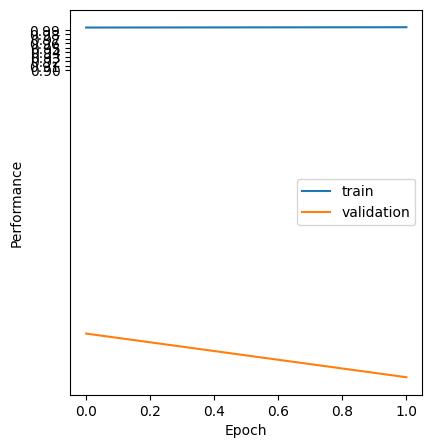

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, train_loss_history, label='train')
plt.plot(epochs, valid_loss_history, label='valid')
plt.legend()
plt.show()

In [ ]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승한다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.9350


In [ ]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승하지 않는다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.3695
